In [4]:
import pandas as pd

data = pd.read_csv('data.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000
1,2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500
2,2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500
3,2015-01-07,14.223333,14.318667,13.985333,14.063333,14.063333,44526000
4,2015-01-08,14.187333,14.253333,14.000667,14.041333,14.041333,51637500


In [7]:
df=data.reset_index()['Close']
df.head()

0    14.620667
1    14.006000
2    14.085333
3    14.063333
4    14.041333
Name: Close, dtype: float64

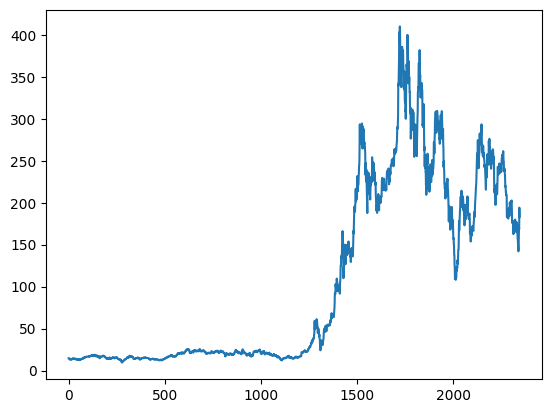

In [8]:
import matplotlib.pyplot as plt
plt.plot(df)

In [10]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
# df=scaler.fit_transform(np.array(df)) # will give error so we have to reshape data
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [11]:
df

array([[0.01259433],
       [0.01105916],
       [0.0112573 ],
       ...,
       [0.39639152],
       [0.46072849],
       [0.43382984]])

In [14]:
##splitting dataset into train and test split
training_size=int(len(df)*0.75)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]

In [15]:
training_size,test_size


(1760, 587)

In [16]:
train_data

array([[0.01259433],
       [0.01105916],
       [0.0112573 ],
       ...,
       [0.86437455],
       [0.8868026 ],
       [0.88224873]])